In [1]:
# ETL
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import Normalizer, StandardScaler

# Evaluating, Scoring and splitting
import scipy.stats
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Saving and loading model
import joblib

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

# Utils
import warnings
warnings.filterwarnings("ignore")

In [2]:
## Functions

# Datavis
def show_number_on_plot(ax):
    for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height() + p.get_height()/80))

In [3]:
## Configs

# paths
data_path = '../02_data/processed/00_pre_modeling_analysis.csv'
save_data_path = '../02_data/processed/01_customer_clusters.csv'
save_model_path = '../05_models/customer_cluster_model.pkl'

# models config
test_size = 0.33
num_folds = 10
seed = 5
num_trees = 100

In [4]:
df = pd.read_csv(data_path)
df_aux = deepcopy(df.drop(['Dt_Customer'], axis=1))

In [5]:
# Eliminating categorical categorical columns
categorical_columns = ['Response',
                       'Complain',
                       'AcceptedCmp1',             
                       'AcceptedCmp2',             
                       'AcceptedCmp3',            
                       'AcceptedCmp4',             
                       'AcceptedCmp5',
                       'Education',
                       'Marital_Status',
                       'accepted_cmp_before']

df_aux = df_aux[list(set(list(df_aux.columns)) - set(categorical_columns))]
df_aux.head()

,NumDealsPurchases,MntWines,MntFruits,NumWebVisitsMonth,qtd_cmp_accepted,NumStorePurchases,MntGoldProds,YearsOfEnrollment,MntSweetProducts,Recency,Income,Teenhome,MntMeatProducts,Age,NumCatalogPurchases,MntFishProducts,NumWebPurchases,Kidhome
0,3,635,88,7,0,4,88,2,88,58,58138.0,0,546,55,10,172,8,0
1,2,11,1,5,0,2,6,0,1,38,46344.0,1,6,60,1,2,1,1
2,1,426,49,4,0,10,42,1,21,26,71613.0,0,127,48,2,111,8,0
3,2,11,4,6,0,4,5,0,3,26,26646.0,0,20,30,0,10,2,1
4,5,173,43,5,0,6,15,0,27,94,58293.0,0,118,33,3,46,5,1


In [6]:
df_aux.dtypes

NumDealsPurchases        int64
MntWines                 int64
MntFruits                int64
NumWebVisitsMonth        int64
qtd_cmp_accepted         int64
NumStorePurchases        int64
MntGoldProds             int64
YearsOfEnrollment        int64
MntSweetProducts         int64
Recency                  int64
Income                 float64
Teenhome                 int64
MntMeatProducts          int64
Age                      int64
NumCatalogPurchases      int64
MntFishProducts          int64
NumWebPurchases          int64
Kidhome                  int64
dtype: object

In [7]:
df_aux = df_aux[['MntGoldProds','Age', 'YearsOfEnrollment', 'Recency', 'NumStorePurchases',
                 'Kidhome', 'Teenhome', 'NumWebPurchases', 'NumDealsPurchases', 'NumCatalogPurchases']]

In [8]:
# Generating normalized data
df_aux = df_aux.values

scaler = Normalizer().fit(df_aux)
df_aux = scaler.transform(df_aux)

pca = PCA(n_components=2).fit_transform(df_aux)

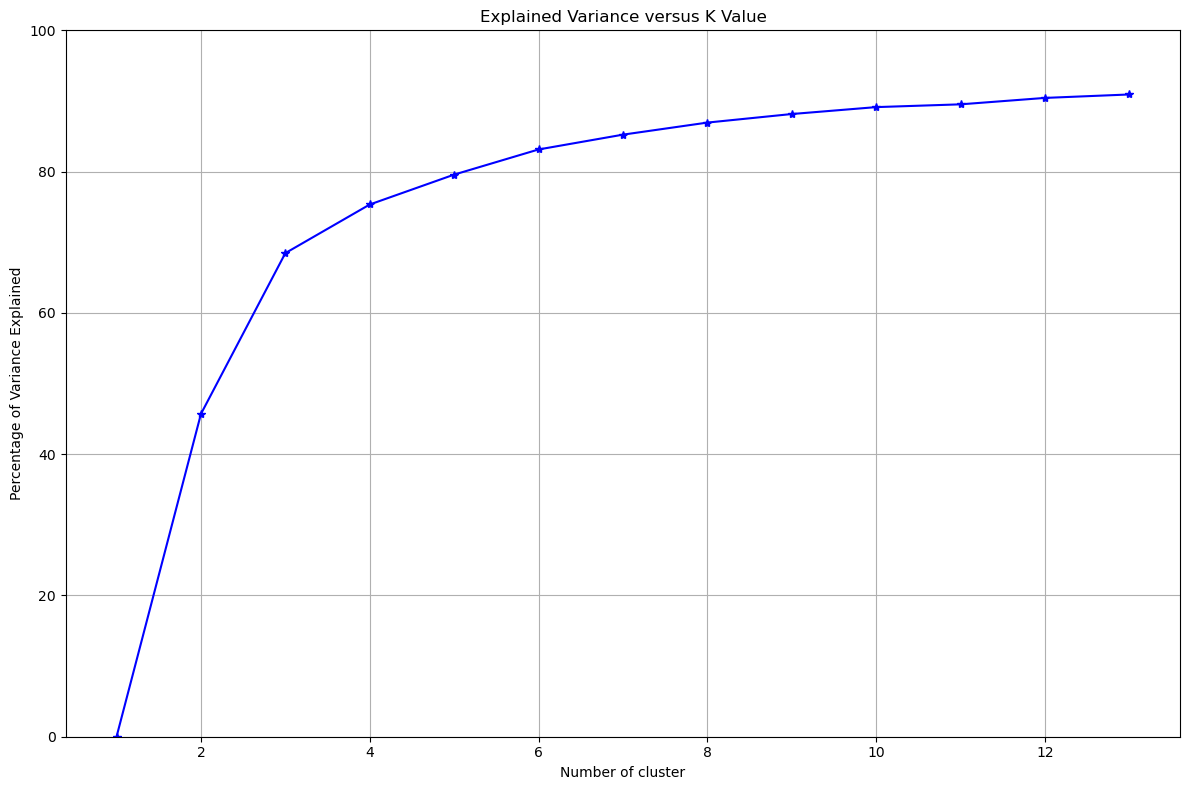

In [9]:
# Plot Size
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)

# K range
k_range = range(1, 14)

# Applying the K-Means model to each value of K (this cell can take a long time to run)
k_means_var = [KMeans(n_clusters = k).fit(df_aux) for k in k_range]

# Tuning the cluster centroid for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculating the Euclidean distance from each data point to the centroid
k_euclid = [cdist(df_aux, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

# Sum of the squares of the distances within the cluster
sum_square_intra_cluster = [sum(d**2) for d in dist]

# total sum of squares
total_sum = sum(pdist(df_aux)**2)/df_aux.shape[0]

# total sum of squares
sum_square_inter_cluster = total_sum - sum_square_intra_cluster

# Results Plot
plt.plot(k_range, sum_square_inter_cluster/total_sum * 100, 'b*-')
ax = plt.gca()
ax.set_ylim([0,100])
plt.grid(True)
plt.xlabel('Number of cluster')
plt.ylabel('Percentage of Variance Explained')
plt.title('Explained Variance versus K Value')

fig.tight_layout()
plt.show()

This plot gives us an overview of the optimal K values to use, clearly K values below 5 cannot explain most of the variance between the data.

From the above, an analysis will be made to verify the optimal value of clusters so that there is no overlap of groups.

In [11]:
# Creating a model with K = 5, 6, 7, 8, 9, 10, 11 and 12
models = dict()

# Training the Models
for i in range(5,14):
    m = KMeans(n_clusters = i)
    models.update({'model_k'+str(i) : m.fit(df_aux)})
    
# Print of Results
for key in models.keys():
    labels = models[key].labels_
    print(key,": ",silhouette_score(df_aux, labels, metric = 'euclidean'))

model_k5 :  0.33118163034796644
model_k6 :  0.3713376248336486
model_k7 :  0.34874695831274405
model_k8 :  0.35454166403563614
model_k9 :  0.3423726001709214
model_k10 :  0.3264881355189684
model_k11 :  0.30211878021000893
model_k12 :  0.2960685412682961
model_k13 :  0.31001894040401085


Given the results above, the optimal number of clusters is not very clear, the metric chosen is very close, we will do the plots in 2d to get better conclusions

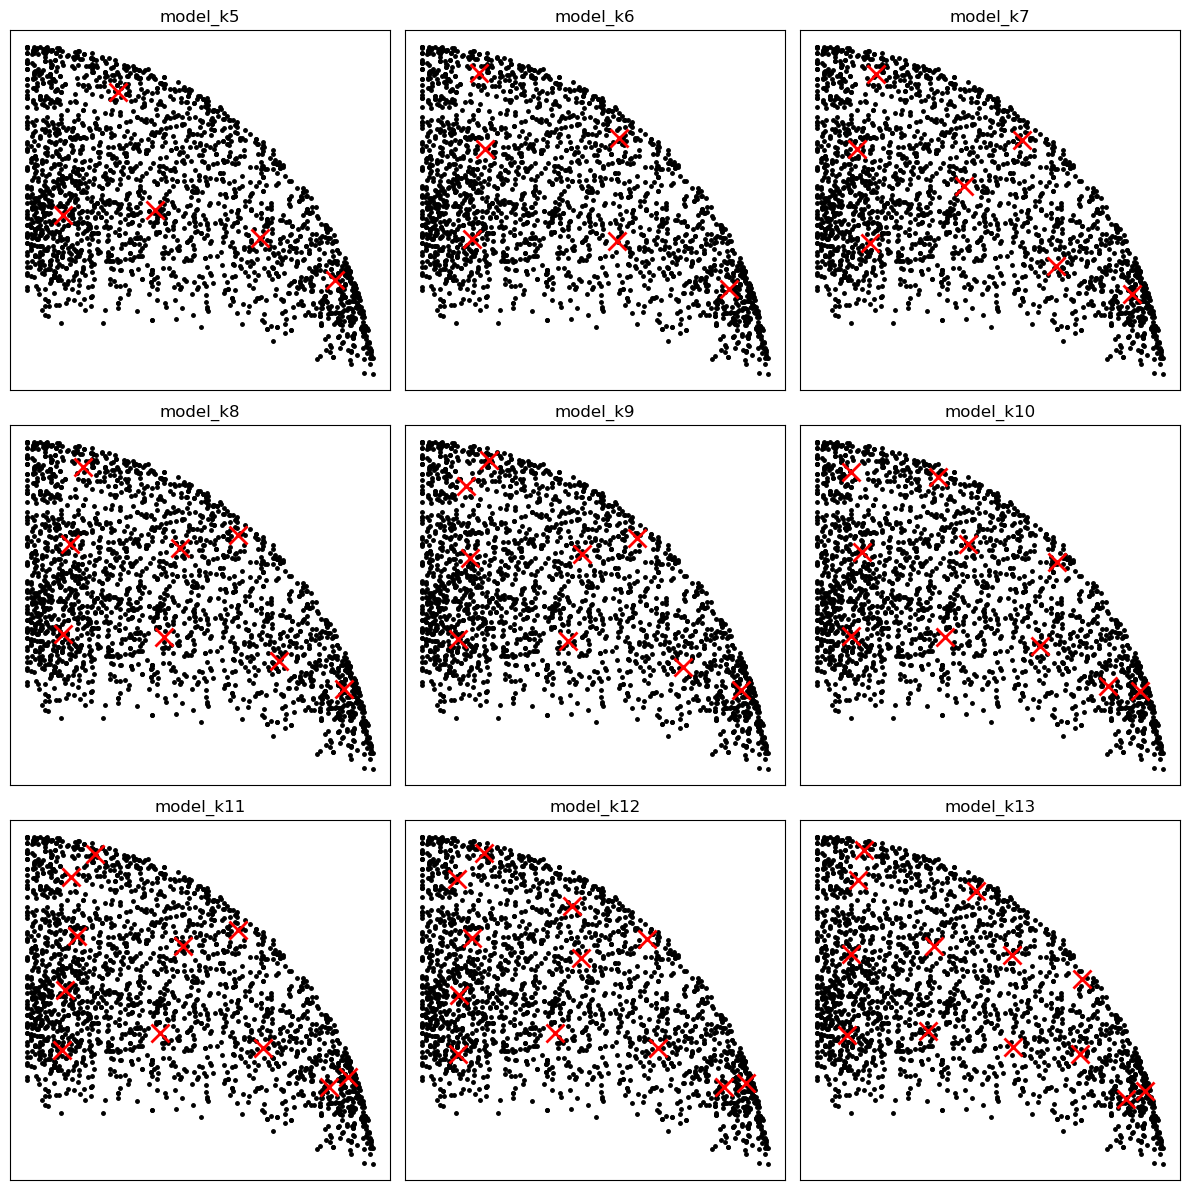

In [13]:
# Setting the size of plots
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)

    
# Centroids Plot
for i, model_k in enumerate(models.keys()):
    
    model = models[model_k]
    
    plt.subplot(3,3, i+1)
    plt.plot(df_aux[:, 0], df_aux[:, 1], 'k.', markersize = 5)
    centroids = model.cluster_centers_
    inert = model.inertia_
    plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 2, color = 'r', zorder = 8)
    plt.title(model_k)
    plt.xticks(())
    plt.yticks(())


fig.tight_layout()
plt.show()

Lets plot cluster points with difertent colors to see overlapping effects

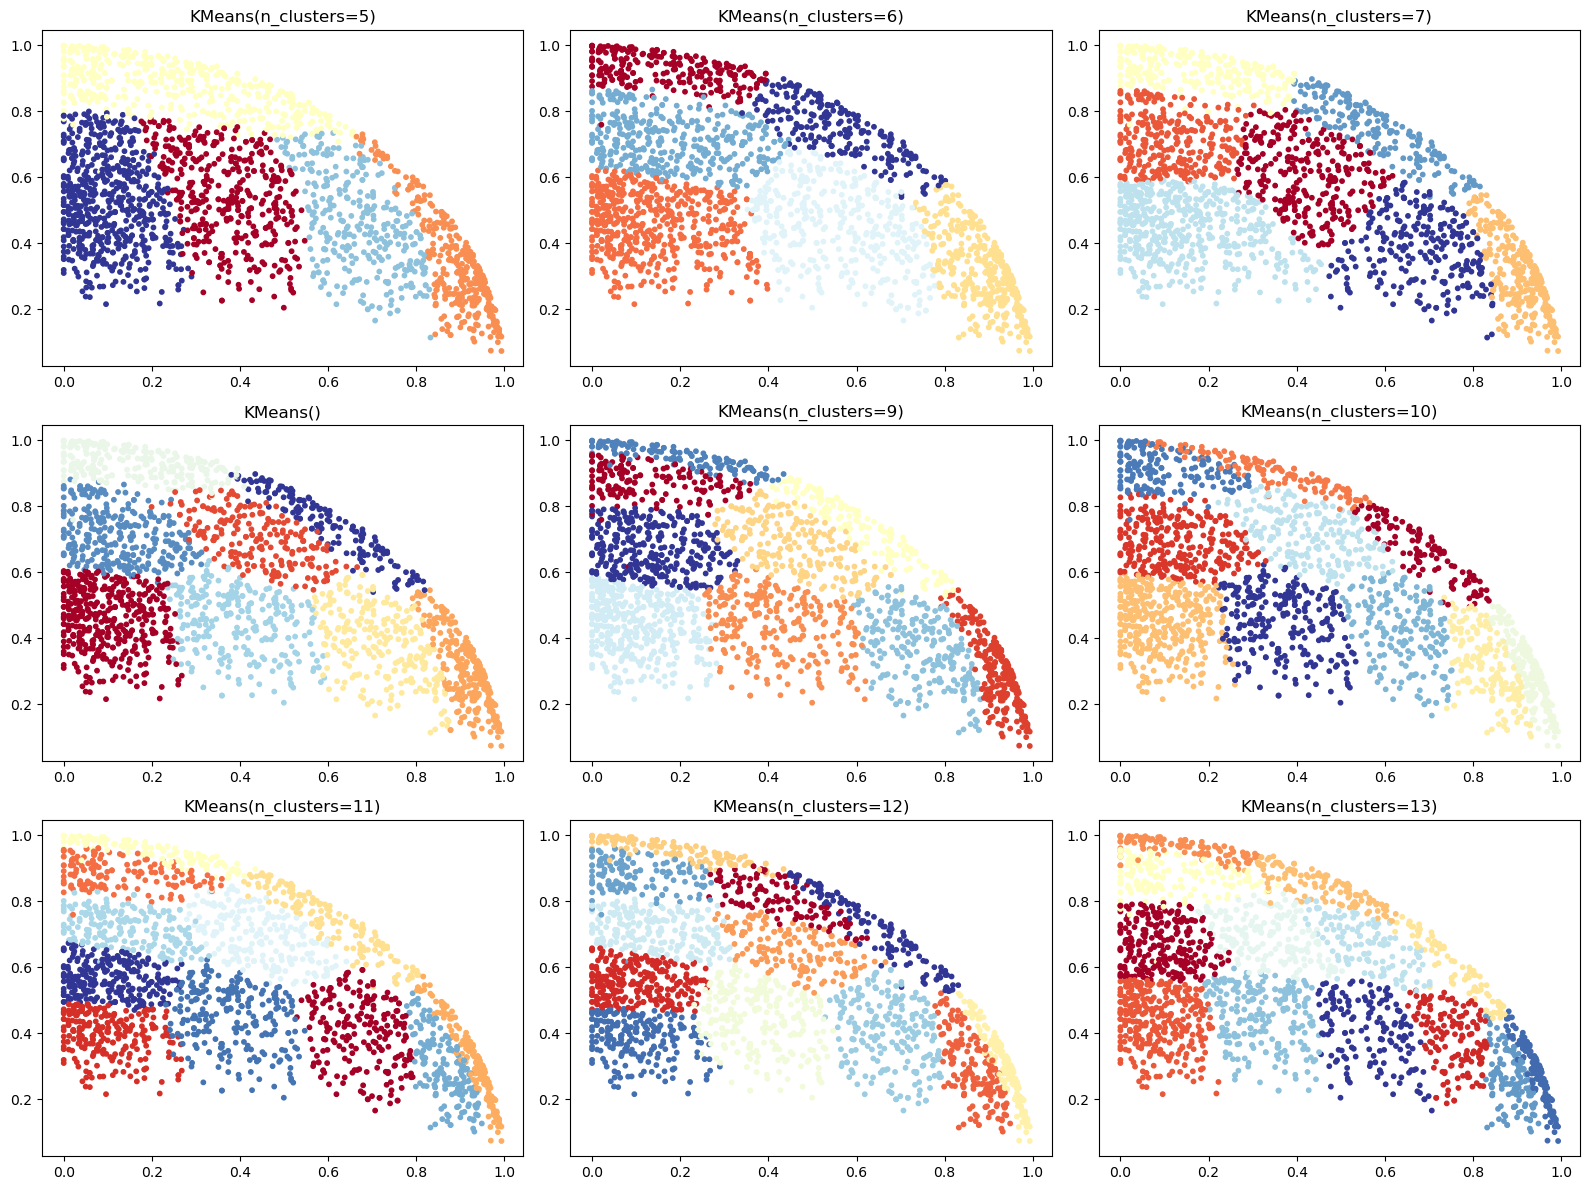

In [15]:
# Plot Gruops
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(16)

for i, model_k in enumerate(models.keys()):
    
    model = models[model_k]
    label = model.labels_
    
    plt.subplot(3,3,i+1)
    plt.scatter(df_aux[:, 0], df_aux[:, 1], c=label, s=10, cmap='RdYlBu')
    plt.title(model)
    
fig.tight_layout()    
plt.show()

there doesn't seem to be a strong overlap between clusters, let's keep 6 cluster since the silouette score is the highest.

In [17]:
model = models['model_k6']
df['Cluster'] = model.labels_ + 1

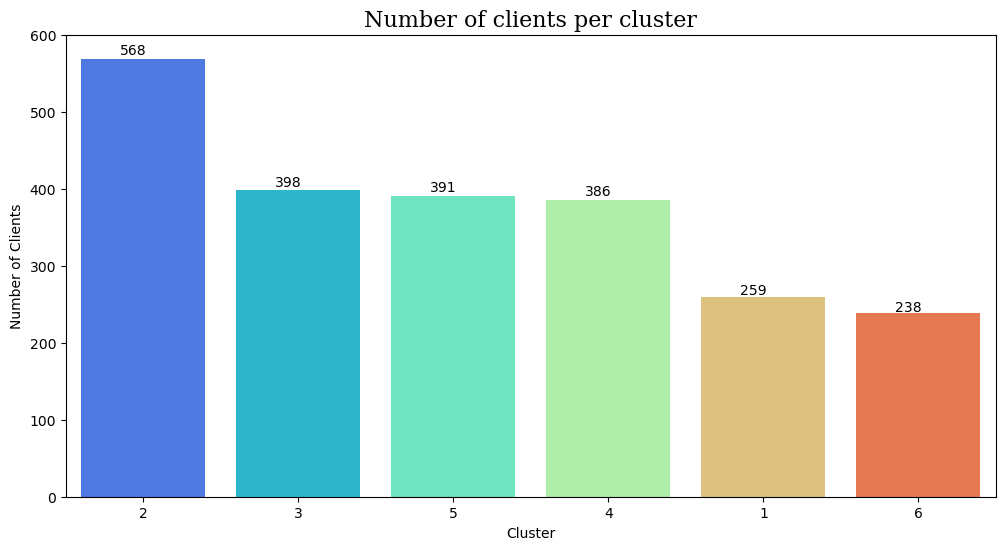

In [18]:
# Count plots 
# Plot os Gruops
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

ax = sns.countplot(x = 'Cluster', data = df, 
                   order = df['Cluster'].value_counts().index,
                   palette = 'rainbow')

plt.title('Number of clients per cluster', fontdict={'family': 'serif',
                                                    'color':  'black',
                                                    'weight': 'normal',
                                                    'size': 16})

plt.ylabel('Number of Clients')
plt.ylim(0,600)

show_number_on_plot(ax)
    
plt.show()

The clusters are not very unbalanced.

Let's create a supervised classification model to classify new customers.

In [20]:
# Data type fixing
df_aux = deepcopy(df.drop('Dt_Customer', axis=1))

for col in categorical_columns:
    
    df_aux[col] = df_aux[col].astype('category')
    df_aux[col] = df_aux[col].cat.codes

In [21]:
# Feature Selection
array = df_aux.values

# creating input and output arrays
X = array[:,:28]
Y = array[:,28]

# Scalling the data
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Creating feature selection model
modelo = ExtraTreesClassifier()
modelo.fit(X, Y)

# Print Results
res = [[round(modelo.feature_importances_[i],4),df_aux.columns[i]] for i in range(len(df_aux.columns)-1)]
res.sort(); res

[[0.0019, 'AcceptedCmp2'],
 [0.0023, 'Complain'],
 [0.0033, 'AcceptedCmp1'],
 [0.004, 'accepted_cmp_before'],
 [0.0049, 'AcceptedCmp5'],
 [0.0061, 'AcceptedCmp4'],
 [0.0068, 'AcceptedCmp3'],
 [0.0106, 'qtd_cmp_accepted'],
 [0.0122, 'Response'],
 [0.0175, 'Kidhome'],
 [0.0203, 'Teenhome'],
 [0.0235, 'YearsOfEnrollment'],
 [0.0244, 'NumDealsPurchases'],
 [0.0259, 'Marital_Status'],
 [0.0266, 'Education'],
 [0.0274, 'NumWebVisitsMonth'],
 [0.0309, 'Income'],
 [0.0337, 'NumStorePurchases'],
 [0.0339, 'NumCatalogPurchases'],
 [0.0357, 'MntSweetProducts'],
 [0.0358, 'NumWebPurchases'],
 [0.0372, 'MntFruits'],
 [0.0376, 'MntMeatProducts'],
 [0.0378, 'MntFishProducts'],
 [0.0394, 'MntWines'],
 [0.0516, 'Age'],
 [0.1885, 'MntGoldProds'],
 [0.2202, 'Recency']]

In [22]:
# let's filter features with importance above 0.03
informative_features = [x[1] for x in res if x[0] >= 0.03]
informative_features

['Income',
 'NumStorePurchases',
 'NumCatalogPurchases',
 'MntSweetProducts',
 'NumWebPurchases',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntWines',
 'Age',
 'MntGoldProds',
 'Recency']

In [23]:
# Filtering dataset
df_aux = df[informative_features]
X = df_aux.values

# Scalling the data
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [24]:
## Testing various models

# Preparing a list of models
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('RFC', RandomForestClassifier()))


# Evaluating each model in a loop
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits = num_folds, random_state = seed, shuffle=True)
    cv_results = cross_val_score(model, X, Y, cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %4f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LDA: 0.820089 (0.027668)
NB: 0.705804 (0.036457)
KNN: 0.737054 (0.039551)
DTC: 0.922768 (0.019259)
SVM: 0.890625 (0.026655)
RFC: 0.922321 (0.012177)


DecisionTreeClassifier and RandomForestClassifier were the most accurate models, we will continue to work with them.

In [26]:
## Optimization

# Separating data in folds
kfold = KFold(num_folds,shuffle=True, random_state = seed)


# Creating a list with best models
best_models = [('RFC', RandomForestClassifier()), ('DTC', DecisionTreeClassifier())]

# Creating a dict to store resulting models 
results = dict()

for name, model_ in best_models:
    
    model = BaggingClassifier(estimator = model_, n_estimators = num_trees, random_state = seed)
    results[name] = model
    result = cross_val_score(model, X, Y, cv = kfold)
    
    print(name, "- Accuracy: %.2f%%" % (result.mean() * 100))


KeyboardInterrupt



The Decision Tree Classifier algorithm was the most performant, we will do some more tests with it before making the final decision.

In [ ]:
# Spliting Data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = seed)

# Selecting and evalueting model
model = results['DTC']
model = model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

print((accuracy_score(Y_test, Y_pred)))

In [ ]:
# Saving Dataset
df.to_csv(save_data_path, index=False)

# Saving model
joblib.dump(model, save_model_path)